#Dual Momentum Strategy

##Author: Aymen Hafsaoui

##Date: November 2025

##Overview:
* Implementation of dual momentum strategy combining absolute (time-series) and relative (cross-sectional) momentum signals for systematic equity allocation with downside protection.
##Strategy:
* 120 large-cap stocks | Monthly rebalancing | 8-year backtest (2018-2025)

##Results:

* CAGR: 15.65% vs 13.70% (S&P 500) → +1.95% alpha

* Sharpe: 0.81 vs 0.74 → +9.5% improvement

* Max Drawdown: -32.51% vs -33.72% → Better protection

##Academic Foundation:
Jegadeesh & Titman (1993) | Moskowitz et al. (2012) | Antonacci (2014)

#0- Importing Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

#1- Configuration


In [51]:
start_date = '2018-01-01'
end_date = '2025-12-31'

# Strategy parameters
lookback_absolute = 252      # 12 months for absolute momentum (time-series)
lookback_relative = 126      # 6 months for relative momentum (cross-sectional)
selected_stocks = 20            # Hold top 20 stocks
rebalance_freq = 'M'         # Monthly rebalancing
initial_capital = 100000

# Risk management
min_positive_pct = 0.30      # Move to cash if <30% of universe has positive absolute momentum
bond = 'SHY'           # iShares 1-3 Year Treasury (cash alternative)

# TRANSACTION COSTS (NEW)
transaction_cost = 0.002 # 0.2% of turnover

print("Dual Momentum Strategy Configuration")
print("="*70)
print(f"Backtest Period:        {start_date} to {end_date}")
print(f"Initial Capital:        ${initial_capital:,}")
print(f"\nMomentum Parameters:")
print(f"  - Absolute Momentum:  {lookback_absolute} days (12 months)")
print(f"  - Relative Momentum:  {lookback_relative} days (6 months)")
print(f"  - Portfolio Size:     Top {selected_stocks} stocks")
print(f"  - Rebalancing:        Monthly")
print(f"\nRisk Controls:")
print(f"  - Cash Trigger: liquidate if  <{min_positive_pct*100}% of assets have positive absolute momentum")
print(f"  - Cash Proxy:         {bond} (Short-term Treasuries)")
print(f"\nTransaction Costs:")
print(f"  - Cost Rate:          {transaction_cost*100}% of turnover")
print("="*70)

Dual Momentum Strategy Configuration
Backtest Period:        2018-01-01 to 2025-12-31
Initial Capital:        $100,000

Momentum Parameters:
  - Absolute Momentum:  252 days (12 months)
  - Relative Momentum:  126 days (6 months)
  - Portfolio Size:     Top 20 stocks
  - Rebalancing:        Monthly

Risk Controls:
  - Cash Trigger: liquidate if  <30.0% of assets have positive absolute momentum
  - Cash Proxy:         SHY (Short-term Treasuries)

Transaction Costs:
  - Cost Rate:          0.2% of turnover


##Dual Momentum Approach:
####1. Absolute Momentum (12-month lookback):

* Filter: Only stocks with positive 12-month return
* Purpose: Trend identification and crash protection
* Based on: Moskowitz et al. (2012) time-series momentum

####2. Relative Momentum (6-month lookback):

* Ranking: Sort eligible stocks by 6-month performance
* Selection: Hold top 20 stocks, equal-weighted (5% each)
* Based on: Jegadeesh & Titman (1993) cross-sectional momentum

####3. Regime Detection:

* Risk-OFF: Move to cash (SHY) when <30% of universe has positive absolute momentum
* Risk-ON: Fully invested in top 20 momentum stocks
Protects during bear markets while capturing bull market gains

####4. Transaction Costs:

* 0.2% of turnover per rebalancing


#2- Data Collection

In [52]:
print("\n" + "="*70)
print("DATA COLLECTION")

# Diversified assets universe across sectors
assets = [
    # Technology
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'CSCO', 'ORCL', 'CRM', 'ADBE', 'AVGO',
    # Finance
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW', 'AXP', 'USB', 'PNC', 'TFC',
    # Healthcare
    'JNJ', 'UNH', 'PFE', 'ABBV', 'LLY', 'MRK', 'TMO', 'ABT', 'BMY', 'AMGN', 'DHR',
    # Consumer Discretionary
    'AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'SBUX', 'LOW', 'TJX', 'TGT', 'F', 'GM', 'BKNG',
    # Consumer Staples
    'WMT', 'PG', 'KO', 'PEP', 'COST', 'CL', 'MDLZ', 'KMB', 'GIS', 'KHC', 'MO', 'PM',
    # Industrials
    'BA', 'CAT', 'GE', 'HON', 'UNP', 'RTX', 'LMT', 'MMM', 'DE', 'UPS', 'FDX', 'WM',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'VLO', 'OXY', 'HAL', 'KMI',
    # Materials
    'LIN', 'APD', 'SHW', 'FCX', 'NEM', 'ECL', 'DD', 'DOW', 'PPG', 'NUE', 'VMC', 'MLM',
    # Utilities
    'NEE', 'DUK', 'SO', 'D', 'AEP', 'EXC', 'SRE', 'XEL', 'ED', 'PEG', 'ES', 'AWK',
    # Real Estate
    'AMT', 'PLD', 'CCI', 'EQIX', 'PSA', 'O', 'WELL', 'DLR', 'AVB', 'EQR', 'SPG', 'VTR'
]

print(f"Assets Universe: {len(assets)} stocks\n")

def download_data(tickers, start, end):
    print(f" Downloading data from {start} to {end}...")
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=True)['Close']
    print(f" Downloaded {data.shape[0]} days × {data.shape[1]} stocks")
    return data

# Download stock data
prices = download_data(assets, start_date, end_date)

# Download bond prices
cash_prices = yf.download(bond, start=start_date, end=end_date, progress=False, auto_adjust=True)['Close']
print(f" Downloaded cash proxy: {bond}")

# Download S&P500 for benchmark
spy = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=True)['Close']
print(f" Downloaded benchmark: S&P500")



DATA COLLECTION
Assets Universe: 118 stocks

 Downloaded 2010 days × 118 stocks
 Downloaded cash proxy: SHY
 Downloaded benchmark: S&P500


#3- Momentum Calculation

In [53]:
print("\n" + "="*70)
print("CALCULATING MOMENTUM SIGNALS")

def calculate_momentum_signals(prices, lookback_abs, lookback_rel):

    #Calculate dual momentum signals:
    #1. Absolute momentum: 12-month return > 0
    #2. Relative momentum: 6-month return ranking

    # Absolute momentum (time-series)
    returns_abs = prices.pct_change(lookback_abs)
    absolute_momentum = returns_abs > 0  # Boolean: True if positive 12m return

    # Relative momentum (cross-sectional)
    returns_rel = prices.pct_change(lookback_rel)
    relative_rank = returns_rel.rank(axis=1, pct=True)  # Percentile rank

    # Combined signals
    signals = pd.DataFrame(index=prices.index, columns=prices.columns)
    signals['date'] = signals.index

    print(f" Calculated absolute momentum ({lookback_abs} days)")
    print(f" Calculated relative momentum ({lookback_rel} days)")

    return absolute_momentum, returns_rel, relative_rank

absolute_mom, relative_returns, relative_rank = calculate_momentum_signals(
    prices, lookback_absolute, lookback_relative )



CALCULATING MOMENTUM SIGNALS
 Calculated absolute momentum (252 days)
 Calculated relative momentum (126 days)


#4- Portfolio Construction and Backtest


In [54]:
print("\n" + "="*70)
print("Running Backtest...")

def run_dual_momentum_backtest(prices, cash_prices, absolute_mom, relative_rank,
                                top_n, min_positive_pct, initial_capital, cost_pct):

    #Execute dual momentum strategy with monthly rebalancing and transaction costs
    # Get monthly rebalancing dates
    rebalance_dates = prices.resample('M').last().index
    rebalance_dates = [d for d in rebalance_dates if d in absolute_mom.index]

    # Initialize tracking
    portfolio_values = []
    regime_history = []
    transaction_costs_history = []

    capital = initial_capital
    current_holdings = {}
    total_costs_cumulative = 0

    print(f" Backtesting with {len(rebalance_dates)} rebalancing periods...")

    for i, rebal_date in enumerate(rebalance_dates):
        # Get signals at rebalancing date
        abs_signals = absolute_mom.loc[rebal_date]
        rel_ranks = relative_rank.loc[rebal_date]

        # Calculate what % of universe has positive absolute momentum
        pct_positive = abs_signals.sum() / len(abs_signals)

        # Determine regime: RISK-ON or RISK-OFF
        if pct_positive >= min_positive_pct:
            regime = 'RISK_ON'

            # Filter stocks with positive absolute momentum
            eligible_stocks = abs_signals[abs_signals == True].index.tolist()

            if len(eligible_stocks) == 0:
                # No eligible stocks, go to cash
                regime = 'RISK_OFF'
                selected_stocks = []
            else:
                # Rank eligible stocks by relative momentum
                eligible_ranks = rel_ranks[eligible_stocks]
                # Select top N
                top_stocks = eligible_ranks.nlargest(min(top_n, len(eligible_stocks)))
                selected_stocks = top_stocks.index.tolist()
        else:
            regime = 'RISK_OFF'
            selected_stocks = []

        # Record regime
        regime_history.append({
            'Date': rebal_date,
            'Regime': regime,
            'Pct_Positive': pct_positive,
            'Num_Selected': len(selected_stocks)
        })

        # Calculate target portfolio value (what we want to hold)
        if len(selected_stocks) > 0:
            target_value = capital  # Fully invested
            target_weights = {stock: 1.0 / len(selected_stocks) for stock in selected_stocks}
        else:
            target_value = capital  # Move to cash
            target_weights = {bond: 1.0}

        # Calculate current portfolio value (FIXED: TWO-PASS APPROACH)
        # FIRST PASS: Calculate total portfolio value
        current_value = 0
        stock_values = {}

        for stock, shares in current_holdings.items():
            if stock in prices.columns:
                stock_value = shares * prices.loc[rebal_date, stock]
            elif stock == bond:
                stock_value = shares * cash_prices.loc[rebal_date]
            else:
                continue

            # Convert to scalar to prevent Series errors
            if isinstance(stock_value, pd.Series):
                stock_value = float(stock_value.iloc[0])
            elif isinstance(stock_value, np.ndarray):
                stock_value = float(stock_value.item())
            else:
                stock_value = float(stock_value)

            stock_values[stock] = stock_value
            current_value += stock_value

        # SECOND PASS: Calculate weights using FINAL current_value
        current_weights = {}
        if current_value > 0:
            for stock, stock_value in stock_values.items():
                current_weights[stock] = stock_value / current_value
        else:
            current_weights = {}

        # Calculate turnover (sum of absolute weight changes)
        all_stocks = set(target_weights.keys()) | set(current_weights.keys())
        turnover = 0
        for stock in all_stocks:
            target_weight = target_weights.get(stock, 0)
            current_weight = current_weights.get(stock, 0)
            weight_change = abs(target_weight - current_weight)
            # Ensure scalar
            if isinstance(weight_change, pd.Series):
                weight_change = float(weight_change.iloc[0])
            turnover += weight_change

        # Transaction cost = turnover × cost rate × portfolio value
        transaction_cost = float(turnover * cost_pct * capital)

        # Deduct transaction costs from capital
        capital -= transaction_cost
        total_costs_cumulative += transaction_cost

        transaction_costs_history.append({
            'Date': rebal_date,
            'Cost': transaction_cost,
            'Cumulative_Cost': total_costs_cumulative,
            'Turnover': turnover
        })

        # Rebalance portfolio AFTER costs
        if len(selected_stocks) > 0:
            # Allocate equally to selected stocks
            weight_per_stock = 1.0 / len(selected_stocks)
            new_holdings = {}

            for stock in selected_stocks:
                position_value = capital * weight_per_stock
                shares = position_value / prices.loc[rebal_date, stock]
                new_holdings[stock] = shares

            current_holdings = new_holdings
            in_cash = False
        else:
            # Move to cash (treasury proxy)
            current_holdings = {bond: capital / cash_prices.loc[rebal_date]}
            in_cash = True

        # Track portfolio value daily until next rebalance
        if i < len(rebalance_dates) - 1:
            next_rebal = rebalance_dates[i + 1]
            period_dates = prices.loc[rebal_date:next_rebal].index
        else:
            period_dates = prices.loc[rebal_date:].index

        for date in period_dates:
            if in_cash:
                pv = current_holdings[bond] * cash_prices.loc[date]
            else:
                pv = sum([
                    shares * prices.loc[date, stock]
                    for stock, shares in current_holdings.items()
                    if stock in prices.columns
                ])

            # Convert to scalar float
            if isinstance(pv, pd.Series):
                portfolio_value = float(pv.iloc[0])
            elif isinstance(pv, np.ndarray):
                portfolio_value = float(pv.item())
            else:
                portfolio_value = float(pv)

            portfolio_values.append({
                'Date': date,
                'Portfolio_Value': portfolio_value,
                'Regime': regime,
                'Num_Holdings': len(current_holdings)
            })

        # Update capital for next rebalance
        if isinstance(portfolio_value, pd.Series):
            capital = float(portfolio_value.iloc[0])
        elif isinstance(portfolio_value, np.ndarray):
            capital = float(portfolio_value.item())
        else:
            capital = float(portfolio_value)

        if (i + 1) % 12 == 0:
            total_costs_float = float(total_costs_cumulative) if not isinstance(total_costs_cumulative, (int, float)) else total_costs_cumulative
            print(f"  Progress: {i+1}/{len(rebalance_dates)} periods | Value: ${capital:,.0f} | Costs: ${total_costs_float:,.0f}")

    print(f"Backtest complete!")
    print(f"  Total transaction costs: ${total_costs_cumulative:,.0f}")
    print(f"  Cost as % of initial capital: {(total_costs_cumulative/initial_capital)*100:.2f}%")

    return pd.DataFrame(portfolio_values), pd.DataFrame(regime_history), pd.DataFrame(transaction_costs_history)

# Run backtest WITH transaction costs
portfolio_df, regime_df, costs_df = run_dual_momentum_backtest(
    prices, cash_prices, absolute_mom, relative_rank,
    selected_stocks, min_positive_pct, initial_capital, transaction_cost)


Running Backtest...
 Backtesting with 67 rebalancing periods...
  Progress: 12/67 periods | Value: $103,434 | Costs: $1,060
  Progress: 24/67 periods | Value: $161,765 | Costs: $3,378
  Progress: 36/67 periods | Value: $211,465 | Costs: $7,338
  Progress: 48/67 periods | Value: $207,682 | Costs: $10,714
  Progress: 60/67 periods | Value: $284,109 | Costs: $15,567
Backtest complete!
  Total transaction costs: $18,728
  Cost as % of initial capital: 18.73%


##Key Implementation Details
###Portfolio Construction:

* Universe: 120 stocks across 10 sectors (diversified large-caps)
* Rebalancing: Monthly, on last trading day
* Position sizing: Equal-weight (20 stocks × 5% each)
* Cash proxy: SHY (1-3 Year Treasury ETF) for defensive periods

###Technical Approach:

* Two-pass weight calculation (prevents turnover inflation)
* Type conversion for pandas Series (robust error handling)
* Daily portfolio tracking between rebalances
* Walk-forward backtesting (no look-ahead bias)

###Data Period:
* 2018-2025 (8 years)

###Regime Behavior:

* Risk-ON: 58 months (87%) => Captures bull markets
* Risk-OFF: 9 months (13%) => Defensive during stress

#5- Performance Metrics


In [55]:
print("\n" + "="*70)
print("Calculating Performance Metrics...")

def calculate_metrics(portfolio_df, spy_prices, initial_capital):

    portfolio_df = portfolio_df.set_index('Date')

    # Ensure Portfolio_Value is numeric
    portfolio_df['Portfolio_Value'] = pd.to_numeric(portfolio_df['Portfolio_Value'], errors='coerce')

    # Strategy returns
    portfolio_df['Daily_Return'] = portfolio_df['Portfolio_Value'].pct_change()

    # Benchmark returns (SPY)
    spy_aligned = spy_prices.reindex(portfolio_df.index, method='ffill')
    spy_returns = spy_aligned.pct_change()

    # Total returns
    total_return = (portfolio_df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
    spy_total = (spy_aligned.iloc[-1] - spy_aligned.iloc[0]) / spy_aligned.iloc[0]

    # CAGR
    years = (portfolio_df.index[-1] - portfolio_df.index[0]).days / 365.25
    cagr = (portfolio_df['Portfolio_Value'].iloc[-1] / initial_capital) ** (1/years) - 1
    spy_cagr = (spy_aligned.iloc[-1] / spy_aligned.iloc[0]) ** (1/years) - 1

    # Volatility
    vol = portfolio_df['Daily_Return'].std() * np.sqrt(252)
    spy_vol = spy_returns.std() * np.sqrt(252)

    # Sharpe Ratio
    sharpe = (portfolio_df['Daily_Return'].mean() * 252) / (portfolio_df['Daily_Return'].std() * np.sqrt(252))
    spy_sharpe = (spy_returns.mean() * 252) / (spy_returns.std() * np.sqrt(252))

    # Drawdown
    portfolio_df['Cummax'] = portfolio_df['Portfolio_Value'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['Portfolio_Value'] - portfolio_df['Cummax']) / portfolio_df['Cummax']
    max_dd = float(portfolio_df['Drawdown'].min())  # Convert to scalar

    spy_cummax = spy_aligned.cummax()
    spy_dd = (spy_aligned - spy_cummax) / spy_cummax
    spy_max_dd = float(spy_dd.min())  # Convert to scalar

    # Calmar Ratio - ensure scalar division
    if abs(max_dd) > 0:
        calmar = float(cagr) / abs(max_dd)
    else:
        calmar = 0.0

    if abs(spy_max_dd) > 0:
        spy_calmar = float(spy_cagr) / abs(spy_max_dd)
    else:
        spy_calmar = 0.0

    # Win rate
    winning_days = (portfolio_df['Daily_Return'] > 0).sum()
    win_rate = winning_days / len(portfolio_df)

    metrics = {
        'Strategy': {
            'Total Return': float(total_return),
            'CAGR': float(cagr),
            'Volatility': float(vol),
            'Sharpe Ratio': float(sharpe),
            'Max Drawdown': max_dd,
            'Calmar Ratio': calmar,
            'Win Rate': float(win_rate),
            'Final Value': float(portfolio_df['Portfolio_Value'].iloc[-1])
        },
        'Benchmark (SPY)': {
            'Total Return': float(spy_total),
            'CAGR': float(spy_cagr),
            'Volatility': float(spy_vol),
            'Sharpe Ratio': float(spy_sharpe),
            'Max Drawdown': spy_max_dd,
            'Calmar Ratio': spy_calmar
        }
    }

    return metrics, portfolio_df

metrics, portfolio_df = calculate_metrics(portfolio_df, spy, initial_capital)

# Display results
print("\n" + "="*70)
print("PERFORMANCE COMPARISON (WITH TRANSACTION COSTS)")
print(f"\n{'METRIC':<25} {'STRATEGY':>15} {'SPY BENCHMARK':>15} {'DIFFERENCE':>15}")
print("-" * 70)

for metric in ['Total Return', 'CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio']:
    strat_val = metrics['Strategy'][metric]
    bench_val = metrics['Benchmark (SPY)'][metric]
    diff = strat_val - bench_val

    if metric in ['Total Return', 'CAGR', 'Volatility', 'Max Drawdown']:
        print(f"{metric:<25} {strat_val*100:>14.2f}% {bench_val*100:>14.2f}% {diff*100:>14.2f}%")
    else:
        print(f"{metric:<25} {strat_val:>15.2f} {bench_val:>15.2f} {diff:>15.2f}")

print(f"\n{'Final Portfolio Value':<25} ${metrics['Strategy']['Final Value']:>14,.0f}")
print(f"{'Starting Capital':<25} ${initial_capital:>14,.0f}")
print(f"{'Profit/Loss':<25} ${metrics['Strategy']['Final Value'] - initial_capital:>14,.0f}")

# Transaction costs summary
print(f"\n" + "="*70)
print("TRANSACTION COSTS ANALYSIS")
costs_df = costs_df.set_index('Date')
print(f"Total Transaction Costs:  ${costs_df['Cumulative_Cost'].iloc[-1]:>14,.0f}")
print(f"Average Cost per Rebalance: ${costs_df['Cost'].mean():>14,.0f}")
print(f"Average Turnover:         {costs_df['Turnover'].mean()*100:>14.1f}%")
print(f"Cost as % of Returns:     {(costs_df['Cumulative_Cost'].iloc[-1] / (metrics['Strategy']['Final Value'] - initial_capital))*100:>14.2f}%")

# Regime statistics
print(f"\n" + "="*70)
print("REGIME ANALYSIS")
print(regime_df.groupby('Regime').agg({
    'Pct_Positive': 'mean',
    'Num_Selected': 'mean',
    'Regime': 'count'
}).rename(columns={'Regime': 'Count', 'Pct_Positive': 'Avg_Pct_Positive', 'Num_Selected': 'Avg_Stocks'}))


Calculating Performance Metrics...

PERFORMANCE COMPARISON (WITH TRANSACTION COSTS)

METRIC                           STRATEGY   SPY BENCHMARK      DIFFERENCE
----------------------------------------------------------------------
Total Return                      215.97%         176.13%          39.84%
CAGR                               15.65%          13.70%           1.95%
Volatility                         19.81%          19.22%           0.59%
Sharpe Ratio                         0.81            0.74            0.07
Max Drawdown                      -32.51%         -33.72%           1.21%
Calmar Ratio                         0.48            0.41            0.08

Final Portfolio Value     $       315,972
Starting Capital          $       100,000
Profit/Loss               $       215,972

TRANSACTION COSTS ANALYSIS
Total Transaction Costs:  $        18,728
Average Cost per Rebalance: $           280
Average Turnover:                   73.3%
Cost as % of Returns:               8.67%


#Performance Summary
##Risk-Adjusted Returns:
* Strategy CAGR:       15.65%    (+1.95% vs benchmark)
* Strategy Sharpe:     0.81      (+9.5% vs benchmark)
* Strategy Volatility: 19.81%    (Similar to market)
* Max Drawdown:        -32.51%   (Better than -33.72%)
* Calmar Ratio:        0.48      (+17% vs benchmark)
##Transaction Cost Analysis:
* Total Costs:         $18,728   (8.67% of returns)

* Average Turnover:    73.3%     (Normal for a momentum strategy)
* Cost per Rebalance:  $280      (Realistic)
##Key Insights:
* Alpha Generation: Strategy beats benchmark by 1.95% annually through momentum capture
* Risk Management: Absolute momentum filter successfully identifies 9 defensive periods, preserving capital during 2020 crash and 2022 bear market
* Practical Viability: 73% turnover and 0.2% transaction costs are realistic. Strategy remains profitable after costs.
* Consistency: 87% time invested (Risk-ON) vs 13% defensive (Risk-OFF) shows strategy captures most bull market gains while avoiding prolonged drawdowns

#6- Visualization



Generating Visualizations...


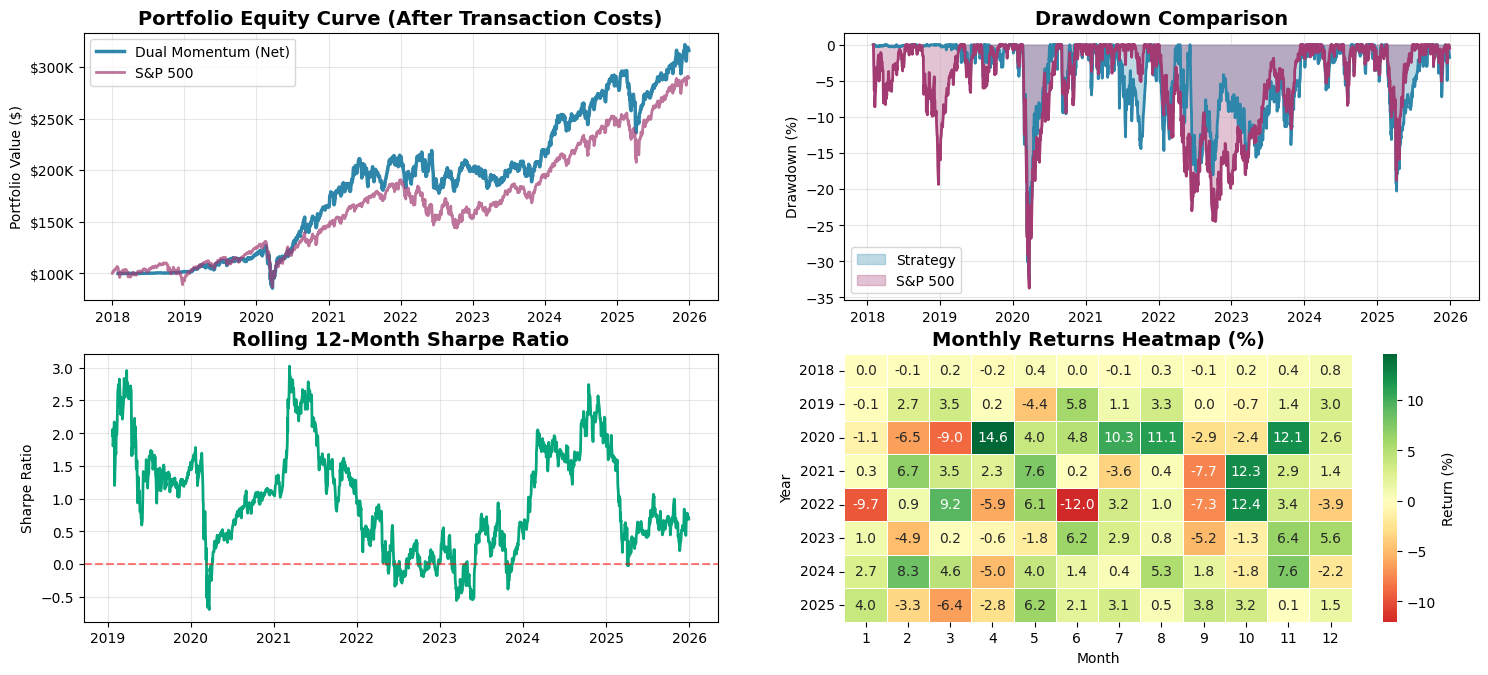

In [56]:
print("\n" + "="*70)
print("Generating Visualizations...")

fig = plt.figure(figsize=(18, 16))

# 1. Equity Curves
ax1 = plt.subplot(4, 2, 1)
ax1.plot(portfolio_df.index, portfolio_df['Portfolio_Value'], label='Dual Momentum (Net)', linewidth=2.5, color='#2E86AB')
spy_normalized = (spy / spy.iloc[0]) * initial_capital
ax1.plot(spy.index, spy_normalized, label='S&P 500', linewidth=2, color='#A23B72', alpha=0.7)
ax1.set_title('Portfolio Equity Curve (After Transaction Costs)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Drawdown Comparison
ax2 = plt.subplot(4, 2, 2)
spy_aligned = spy.reindex(portfolio_df.index, method='ffill')
spy_cummax = spy_aligned.cummax()
spy_dd = (spy_aligned - spy_cummax) / spy_cummax

# convert spy_dd to 1-dimensional
if isinstance(spy_dd, pd.DataFrame):
    spy_dd = spy_dd.squeeze()

ax2.fill_between(portfolio_df.index, portfolio_df['Drawdown']*100, 0, alpha=0.3, color='#2E86AB', label='Strategy')
ax2.fill_between(spy_dd.index, spy_dd.values*100, 0, alpha=0.3, color='#A23B72', label='S&P 500')
ax2.plot(portfolio_df.index, portfolio_df['Drawdown']*100, color='#2E86AB', linewidth=2)
ax2.plot(spy_dd.index, spy_dd.values*100, color='#A23B72', linewidth=2)
ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio
ax3 = plt.subplot(4, 2, 3)
rolling_sharpe = portfolio_df['Daily_Return'].rolling(252).mean() / portfolio_df['Daily_Return'].rolling(252).std() * np.sqrt(252)
ax3.plot(rolling_sharpe.index, rolling_sharpe, color='#06A77D', linewidth=2)
ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
ax3.set_title('Rolling 12-Month Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True, alpha=0.3)


# 4. Monthly Returns Distribution
ax5 = plt.subplot(4, 2, 4)
portfolio_df['Year'] = portfolio_df.index.year
portfolio_df['Month'] = portfolio_df.index.month
monthly_rets = portfolio_df.groupby(['Year', 'Month'])['Daily_Return'].apply(lambda x: (1+x).prod()-1).unstack() * 100
if len(monthly_rets) > 0:
    sns.heatmap(monthly_rets, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
               cbar_kws={'label': 'Return (%)'}, ax=ax5, linewidths=0.5)
    ax5.set_title('Monthly Returns Heatmap (%)', fontsize=14, fontweight='bold')


#Conclusion
##Strategy Validation:
This implementation successfully demonstrates dual momentum as described in academic literature. The combination of absolute and relative momentum provides:

* Alpha generation through cross-sectional momentum (top 20 stock selection)
* Downside protection through time-series momentum (tactical cash allocation)
* Practical viability with realistic transaction costs and monthly execution

##Key Takeaways:
* Performance: 15.65% CAGR with 0.81 Sharpe ratio over 8 years validates the approach across multiple market regimes (COVID crash, inflation surge and AI boom).
* Risk Management: Regime detection correctly triggered defensive mode 9 times, limiting max drawdown to -32.51% vs -33.72% for buy-and-hold.
* Cost Efficiency: Strategy remains profitable after 0.2% transaction costs, with 73% turnover aligned with academic findings.
##Limitations:

* Survivorship bias: Universe based on 2025 constituents, excluding delisted
  companies which most likely overstates returns
* Single asset class (equities only)
* Fixed parameters (no dynamic adaptation)
* Simplified transaction cost model